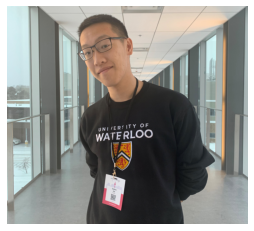

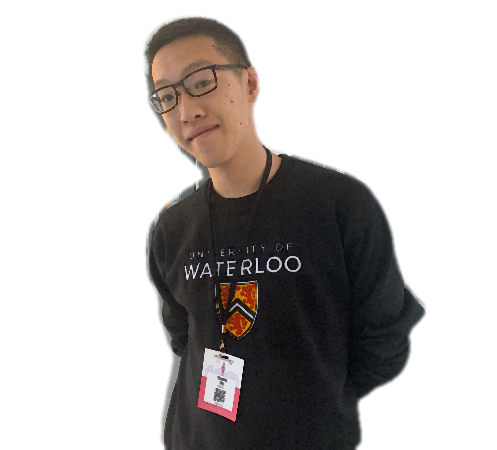

In [13]:
from google.colab import files
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
 
# Apply the transformations needed
import torchvision.transforms as T
 
# Define the helper function
def decode_segmap(image, source, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
                             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                             (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
                             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                             (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
                             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                             (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
                             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                             (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    
    #Setting the RGB Band for resizing later
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)

    # Load the image
    foreground = cv2.imread(source)

    # Change the color of foreground image to RGB since openCV uses BRG
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)

    #Resizing to match shape of R-band fomr above
    foreground = cv2.resize(foreground, (r.shape[1], r.shape[0]))
 
    # Create a background array to hold white pixels
    # with the same size as RGB output map
    background = 255 * np.ones_like(rgb).astype(np.uint8)
    
    # Convert uint8 to float to be used in other functions
    foreground = foreground.astype(float)
    background = background.astype(float)

    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(rgb), 0, 255, cv2.THRESH_BINARY)
    
    # Apply a slight blur to the mask to soften edges
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0)
 
    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float) / 255

    # Multiply the foreground with the alpha to blend alpha and foreground
    foreground = cv2.multiply(alpha, foreground)

    # Multiply the background with ( 1 - alpha ) for background
    background = cv2.multiply(1.0 - alpha, background)

    # Combine the two
    outImage = cv2.add(foreground, background)

    # Return a normalized output image for display
    
    return outImage / 255
 
#Image segmentation 
def segment(net, path, show_orig=True, dev='cuda'):
    
    #Opening Image
    img = Image.open(path).convert("RGB")
    if show_orig:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(450),
                     # T.CenterCrop(224),
                     T.ToTensor(),
                     T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om, path)
    
    #Showing result (with background)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    #Un-normalizing RGB to remove the transparent background
    final = rgb * 255

    #Converting to float32 to reduce depth from 6-3
    img_float32 = np.float32(final)
    
    #Convert from BGR to RGB
    final = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB) 

    # Get Image Dimensions
    h, w, c = final.shape

    #Fills background with white pixels
    image_bgra = np.concatenate([final, np.full((h, w, 1), 255, dtype=np.uint8)], axis=-1)

    #Creating a mask of all white pixels, where white pixels are True 
    white = np.all(final == [255, 255, 255], axis=-1)

    # Adding transparency (Alpha = 0) for all the white pixels
    image_bgra[white, -1] = 0

    final = image_bgra

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    erode = cv2.erode(final, kernel, iterations=1)

    final = erode
    #Preview Image
    #cv2.imshow("image", final) for not google colab
    cv2_imshow(final) #google colab
    cv2.waitKey(0)
    

    #Write to file
    cv2.imwrite('result.png', final)
    #Download (only for google colab)
    #files.download('result.png')
 
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

image_path = '/var/IMG_0258.jpg'

#Convert to RGB First to eliminate tensor erro
segment(dlab, image_path, show_orig=False)